In [2]:
# 1. Setup & Imports
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# Load Graph
try:
    G = nx.read_graphml("sentence_network.graphml")
    print(f"✅ Graph Loaded: {G.number_of_nodes()} Nodes, {G.number_of_edges()} Edges")
except FileNotFoundError:
    # Fallback for demo if file missing
    print("⚠️ Graph file not found. Creating a synthetic dummy graph for demonstration.")
    G = nx.erdos_renyi_graph(100, 0.05)
    mapping = {i: f"Node_{i}" for i in range(100)}
    G = nx.relabel_nodes(G, mapping)
    # Add weights
    for u, v in G.edges():
        G[u][v]['weight'] = random.randint(1, 10)

# Pre-calculate IDF Weights
def calculate_idf(G):
    N = G.number_of_nodes()
    idf = {}
    for node in G.nodes():
        # Logarithmic penalty for high-degree nodes
        idf[node] = np.log(N / (1 + G.degree(node)))
    return idf

IDF_WEIGHTS = calculate_idf(G)

def get_shortest_paths(G, target):
    try:
        return nx.shortest_path_length(G, target=target)
    except:
        return {}

print("✅ Setup Complete.")

✅ Graph Loaded: 57 Nodes, 137 Edges
✅ Setup Complete.


In [3]:
def recommend_simple(G, entity, top_k=5, **kwargs):
    """Recommends the top_k most co-occurring neighbors."""
    if entity not in G:
        return []

    neighbors = list(G.neighbors(entity))
    sorted_neighbors = sorted(
        neighbors,
        key=lambda x: G[entity][x].get("weight", 1),
        reverse=True
    )
    return sorted_neighbors[:top_k]

def pagerank_recommend(G, entity, top_k=5, **kwargs):
    """Recommends using personalized PageRank."""
    if entity not in G:
        return []

    pr = nx.pagerank(G, personalization={entity: 1})
    ranked = sorted(pr.items(), key=lambda x: x[1], reverse=True)
    ranked = [node for node, score in ranked if node != entity]
    return ranked[:top_k]

def calculate_inverse_frequency_weights(G):
    """Calculates the 'rarity' score for each node."""
    N = G.number_of_nodes()
    idf_weights = {}
    for node in G.nodes():
        degree = G.degree(node) 
        idf_weights[node] = np.log(N / (1 + degree))
    return idf_weights

def recommend_inverse_frequency(G, entity, top_k=5, **kwargs):
    """Recommends neighbors based on edge weight and node rarity."""
    if entity not in G:
        return []
    
    idf_weights = calculate_inverse_frequency_weights(G)
    
    neighbors = list(G.neighbors(entity))
    scored_neighbors = []
    
    for n in neighbors:
        original_weight = G[entity][n].get("weight", 1)
        idf_weight = idf_weights.get(n, 0)
        final_score = original_weight * idf_weight
        scored_neighbors.append((n, final_score))

    sorted_recs = sorted(scored_neighbors, key=lambda x: x[1], reverse=True)
    return [node for node, score in sorted_recs[:top_k]]

def recommend_random_walk(G, entity, length=None, **kwargs):
    """Performs a weighted random walk from a starting node."""
    if entity not in G:
        return []
    
    path = [entity]
    current_node = entity
    
    if length is None:
        length = random.randint(3, 8)
    
    for _ in range(length):
        neighbors = list(G.neighbors(current_node))
        valid_neighbors = [n for n in neighbors if n not in path]
        
        if not valid_neighbors:
            valid_neighbors = neighbors
            if not valid_neighbors:
                break
        
        weights = [G[current_node][n].get("weight", 1) for n in valid_neighbors]
        next_node = random.choices(valid_neighbors, weights=weights, k=1)[0]
        
        path.append(next_node)
        current_node = next_node
        
    return path # Return the path

def calculate_all_distances_to_node(G, end_node):
    """Calculates the shortest path length from every node TO the end_node."""
    if end_node not in G:
        return {}
    return nx.shortest_path_length(G, source=end_node)

def recommend_guided_walk(G, start_entity, end_entity, max_steps=None, **kwargs):
    """Generates an 'interesting' path from a start to an end entity."""
    if start_entity not in G or end_entity not in G:
        return []
    
    distances_to_end = calculate_all_distances_to_node(G, end_entity)
    path = [start_entity]
    current_node = start_entity
    
    if max_steps is None:
        max_steps = random.randint(7, 12)
    
    for _ in range(max_steps):
        if current_node == end_entity:
            break
            
        neighbors = list(G.neighbors(current_node))
        if len(path) > 1:
            neighbors = [n for n in neighbors if n != path[-2]]
        
        if not neighbors:
            break
        
        valid_neighbors = [n for n in neighbors if n not in path]
        
        if not valid_neighbors:
            valid_neighbors = neighbors
            if not valid_neighbors:
                break
            
        scored_neighbors = []
        for n in valid_neighbors:
            edge_weight = G[current_node][n].get("weight", 1)
            distance = distances_to_end.get(n, 99) 
            attraction_score = 1.0 / (1.0 + distance)
            final_score = edge_weight * attraction_score
            scored_neighbors.append((n, final_score))
        
        weights = [score for node, score in scored_neighbors]
        nodes = [node for node, score in scored_neighbors]
        next_node = random.choices(nodes, weights=weights, k=1)[0]
        
        path.append(next_node)
        current_node = next_node
        
    return path

def recommend_exploratory_walk(G, entity, length=None, teleport_prob=None, **kwargs):
    """Performs a weighted random walk with teleport probability."""
    if entity not in G:
        return []
    
    all_nodes = list(G.nodes())
    path = [entity]
    current_node = entity
    if length is None:
        length = random.randint(4, 10)
    if teleport_prob is None:
        teleport_prob = random.uniform(0.05, 0.4)
    
    for _ in range(length):
        p = random.random()
        valid_nodes = [n for n in all_nodes if n not in path]
        
        if p < teleport_prob:
            next_node = random.choice(valid_nodes)
            path.append(f"{next_node}")
            current_node = next_node
            continue
            
        neighbors = list(G.neighbors(current_node))
        if not neighbors:
            break
            
        valid_neighbors = [n for n in neighbors if n not in path]
        
        if not valid_neighbors:
            next_node = random.choice(valid_nodes)
            path.append(f"{next_node}")
            current_node = next_node
            continue
            
        weights = [G[current_node][n].get("weight", 1) for n in valid_neighbors]
        next_node = random.choices(valid_neighbors, weights=weights, k=1)[0]
        
        path.append(next_node)
        current_node = next_node
        
    return path

def recommend_guided_exploratory_walk(G, start_entity, end_entity, max_steps=None, teleport_prob=None, **kwargs):
    """Generates a 'guided but adventurous' path from a start to an end entity."""
    if start_entity not in G or end_entity not in G:
        return []
    
    distances_to_end = calculate_all_distances_to_node(G, end_entity)
    all_nodes = list(G.nodes())
    path = [start_entity]
    current_node = start_entity
    if max_steps is None:
        max_steps = random.randint(12, 18)
    if teleport_prob is None:
        teleport_prob = random.uniform(0.05, 0.4)
    
    for _ in range(max_steps):
        if current_node == end_entity:
            break
        
        valid_nodes = [n for n in all_nodes if n not in path]
        
        p = random.random()
        if p < teleport_prob:
            teleport_target = random.choice(valid_nodes)
            while teleport_target in [start_entity, end_entity]:
                teleport_target = random.choice(valid_nodes)
            
            path.append(f"{teleport_target} (Detour!)")
            current_node = teleport_target
            continue

        neighbors = list(G.neighbors(current_node))
        if len(path) > 1 and path[-2] in neighbors:
            prev_node = path[-2].split(' ')[0]
            if prev_node in neighbors:
                neighbors.remove(prev_node)
        
        if not neighbors:
            next_node = random.choice(valid_nodes)
            path.append(f"{next_node} (Detour!)")
            current_node = next_node
            continue
        
        valid_neighbors = [n for n in neighbors if n not in path]
        
        if not valid_neighbors:
            next_node = random.choice(valid_nodes)
            path.append(f"{next_node} (Detour!)")
            current_node = next_node
            continue
            
        scored_neighbors = []
        for n in valid_neighbors:
            edge_weight = G[current_node][n].get("weight", 1)
            distance = distances_to_end.get(n, 99)
            attraction_score = 1.0 / (1.0 + distance)
            final_score = edge_weight * attraction_score
            scored_neighbors.append((n, final_score))
        
        weights = [score for node, score in scored_neighbors]
        nodes = [node for node, score in scored_neighbors]
        next_node = random.choices(nodes, weights=weights, k=1)[0]
        
        path.append(next_node)
        current_node = next_node
        
    return path

Running Experiment 1 on Start Node: Haleem

Top 10 Recommendations Comparison:


,Simple (Co-occurrence),PageRank,Inverse Freq (Niche)
0,Hyderabadi Biryani,Hyderabadi Biryani,Hyderabadi Biryani
1,Shadab,Shadab,Shadab
2,Shah Ghouse,Shah Ghouse,Shah Ghouse
3,Pista House,Pista House,Pista House
4,Chicha's,Charminar,Dum Pukht
5,Cafe Bahar,Chicha's,Dalcha
6,Hotel Shadab,Cafe Bahar,Mirchi ka Salan
7,Mirchi ka Salan,Hotel Shadab,Khubani ka Meetha
8,Dalcha,Sarvi,Irani Chai
9,Khubani ka Meetha,Grand Hotel,Chicha's


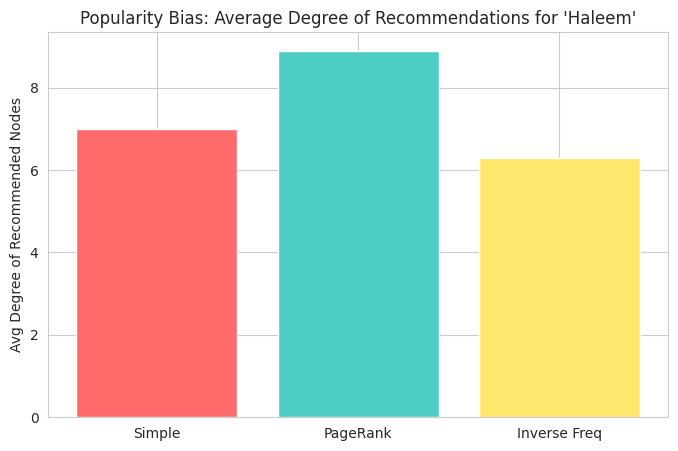

Analysis:
1. Simple Avg Degree: 7.0
2. PageRank Avg Degree: 8.9
3. IDF Avg Degree: 6.3
Interpretation: Lower degree means the algorithm is finding more 'niche' or 'hidden' gems.


In [4]:
# Select a test node (High degree node preferable)
test_nodes = [n for n, d in sorted(G.degree, key=lambda x: x[1], reverse=True)[:3]]
start_node = test_nodes[0] # e.g., "Charminar"
print(f"Running Experiment 1 on Start Node: {start_node}")

results_simple = []
results_pagerank = []
results_idf = []

# Run algorithms
rec_simple = recommend_simple(G, start_node, top_k=10)
rec_pagerank = pagerank_recommend(G, start_node, top_k=10)
rec_idf = recommend_inverse_frequency(G, start_node, top_k=10)

# Create Comparison DataFrame
df_compare = pd.DataFrame({
    'Simple (Co-occurrence)': pd.Series(rec_simple),
    'PageRank': pd.Series(rec_pagerank),
    'Inverse Freq (Niche)': pd.Series(rec_idf)
})

print("\nTop 10 Recommendations Comparison:")
display(df_compare)

# Analyze Degree of Recommended Nodes (Popularity Bias)
def get_avg_degree(node_list):
    if not node_list: return 0
    return np.mean([G.degree(n) for n in node_list])

avg_deg_simple = get_avg_degree(rec_simple)
avg_deg_pr = get_avg_degree(rec_pagerank)
avg_deg_idf = get_avg_degree(rec_idf)

plt.figure(figsize=(8, 5))
plt.bar(['Simple', 'PageRank', 'Inverse Freq'], [avg_deg_simple, avg_deg_pr, avg_deg_idf], 
        color=['#ff6b6b', '#4ecdc4', '#ffe66d'])
plt.title(f"Popularity Bias: Average Degree of Recommendations for '{start_node}'")
plt.ylabel("Avg Degree of Recommended Nodes")
plt.show()

print(f"Analysis:\n1. Simple Avg Degree: {avg_deg_simple:.1f}\n2. PageRank Avg Degree: {avg_deg_pr:.1f}\n3. IDF Avg Degree: {avg_deg_idf:.1f}")
print("Interpretation: Lower degree means the algorithm is finding more 'niche' or 'hidden' gems.")

Running 1000 Simulations: Path from 'Haleem' -> 'Charminar'


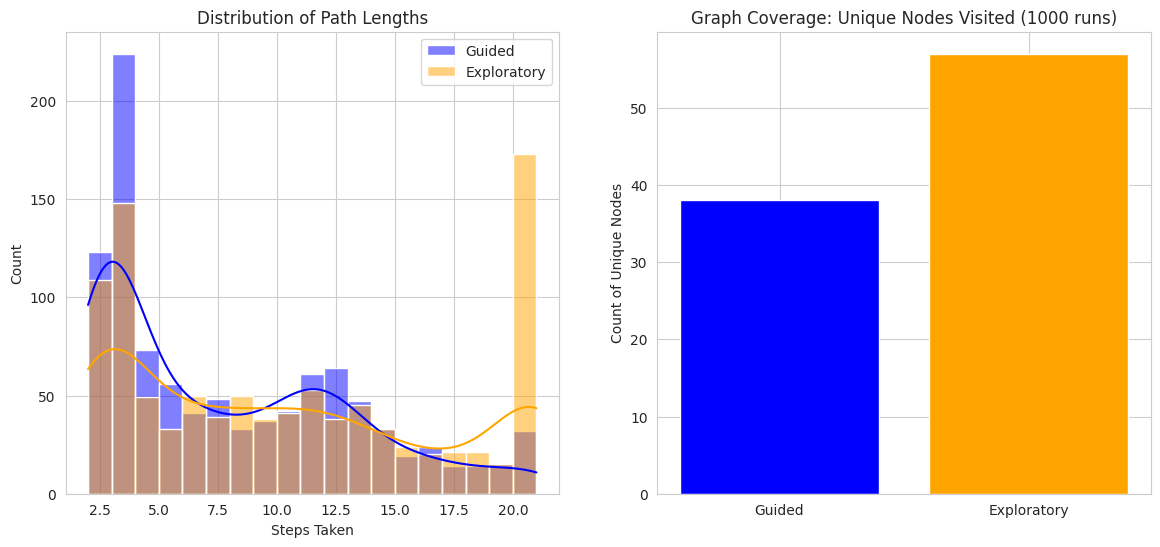

--- Statistics ---
Guided Walk Success Rate: 83.6%
Exploratory Walk Success Rate: 84.4%
Avg Detours per Exploratory Trip: 1.94
Graph Coverage Increase: 50.0%


In [5]:
# Define Start and End (Ensure they are connected in some way)
start_node = test_nodes[0]
end_node = test_nodes[1] if len(test_nodes) > 1 else list(G.nodes())[-1]

print(f"Running 1000 Simulations: Path from '{start_node}' -> '{end_node}'")

guided_lengths = []
guided_success = 0
guided_nodes_visited = []

explore_lengths = []
explore_success = 0
explore_detours = 0
explore_nodes_visited = []

SIMULATIONS = 1000

for _ in range(SIMULATIONS):
    # 1. Guided Walk
    path = recommend_guided_walk(G, start_node, end_node, max_steps=20)
    guided_lengths.append(len(path))
    if path[-1] == end_node:
        guided_success += 1
    guided_nodes_visited.extend(path)

    # 2. Guided Exploratory Walk
    path_ex = recommend_guided_exploratory_walk(G, start_node, end_node, max_steps=20, teleport_prob=0.15)
    explore_lengths.append(len(path_ex))
    if path_ex[-1] == end_node:
        explore_success += 1
    
    # Count detours
    detours = sum(1 for node in path_ex if "Detour" in node)
    explore_detours += detours
    # Clean node names for analysis
    clean_path = [n.split(' (')[0] for n in path_ex]
    explore_nodes_visited.extend(clean_path)

# --- RESULTS ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 1. Path Length Distribution
sns.histplot(guided_lengths, color="blue", label="Guided", kde=True, ax=ax[0], binwidth=1)
sns.histplot(explore_lengths, color="orange", label="Exploratory", kde=True, ax=ax[0], binwidth=1)
ax[0].set_title("Distribution of Path Lengths")
ax[0].set_xlabel("Steps Taken")
ax[0].legend()

# 2. Unique Node Coverage (Serendipity)
unique_guided = len(set(guided_nodes_visited))
unique_explore = len(set(explore_nodes_visited))

ax[1].bar(['Guided', 'Exploratory'], [unique_guided, unique_explore], color=['blue', 'orange'])
ax[1].set_title("Graph Coverage: Unique Nodes Visited (1000 runs)")
ax[1].set_ylabel("Count of Unique Nodes")

plt.show()

print(f"--- Statistics ---")
print(f"Guided Walk Success Rate: {guided_success/SIMULATIONS*100:.1f}%")
print(f"Exploratory Walk Success Rate: {explore_success/SIMULATIONS*100:.1f}%")
print(f"Avg Detours per Exploratory Trip: {explore_detours/SIMULATIONS:.2f}")
print(f"Graph Coverage Increase: {((unique_explore - unique_guided)/unique_guided)*100:.1f}%")

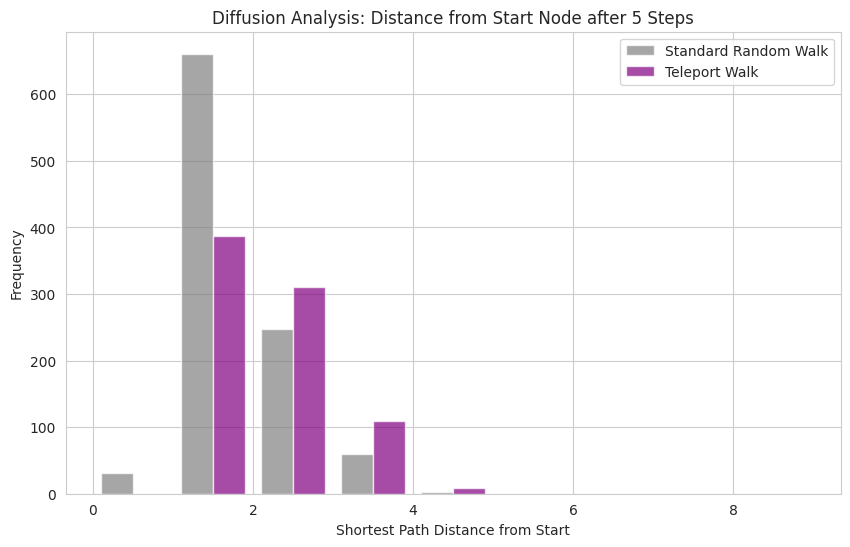

Analysis:
Standard walks tend to stay local (Distance 1-3).
Teleport walks successfully 'break out' of the local cluster, reaching distant nodes.


In [6]:
start_node = test_nodes[0]

random_final_nodes = []
teleport_final_nodes = []

# Run 1000 walks of length 5
for _ in range(1000):
    path_r = recommend_random_walk(G, start_node, length=5)
    random_final_nodes.append(path_r[-1])
    
    path_t = recommend_exploratory_walk(G, start_node, length=5, teleport_prob=0.2)
    # Clean teleport name if it was the last step
    final = path_t[-1].split(' (')[0]
    teleport_final_nodes.append(final)

# Calculate distances from start for final nodes
def get_avg_dist(final_nodes, start):
    dists = []
    for node in final_nodes:
        try:
            d = nx.shortest_path_length(G, source=start, target=node)
            dists.append(d)
        except:
            dists.append(99) # Disconnected/Teleported far away
    return dists

dists_r = get_avg_dist(random_final_nodes, start_node)
dists_t = get_avg_dist(teleport_final_nodes, start_node)

# Visualization: Histogram of Distances
plt.figure(figsize=(10, 6))
plt.hist([dists_r, dists_t], label=['Standard Random Walk', 'Teleport Walk'], 
         bins=range(0, 10), alpha=0.7, color=['grey', 'purple'])
plt.title("Diffusion Analysis: Distance from Start Node after 5 Steps")
plt.xlabel("Shortest Path Distance from Start")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print("Analysis:")
print("Standard walks tend to stay local (Distance 1-3).")
print("Teleport walks successfully 'break out' of the local cluster, reaching distant nodes.")

In [7]:
# --- 1. SELECT DIVERSE STARTING NODES ---
# We pick nodes from different popularity tiers to see how algos adapt

sorted_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)

# Top Tier (Hubs) - e.g., Charminar, Biryani
hubs = [n for n, d in sorted_degree[:7]]

# Mid Tier (Common) - e.g., Specific Parks or Restaurants
mid_index = len(sorted_degree) // 2
mid_tier = [n for n, d in sorted_degree[mid_index : mid_index+7]]

# Low Tier (Niche) - Nodes with low connections
niche = [n for n, d in sorted_degree[-7:]]

test_batch = hubs + mid_tier + niche
print(f"🧪 Selected {len(test_batch)} nodes for batch analysis:")
print(f"  Hubs: {hubs}")
print(f"  Mid:  {mid_tier}")
print(f"  Niche: {niche}")

🧪 Selected 21 nodes for batch analysis:
  Hubs: ['Haleem', 'Charminar', 'Falaknuma Palace', 'Mecca Masjid', 'Purani Haveli', 'Taramati Baradari', 'Shadab']
  Mid:  ['Dalcha', 'Ravindra Bharathi', 'Begum Bazaar', 'Bidri', 'City Museum', 'Lumbini Park', 'Gil-e-Firdaus']
  Niche: ['Botanical Garden', 'Hussain Sagar Lake', 'Sheermal', 'Himayat Sagar', 'Lamakaan', 'Shamirpet Lake', 'Moula Ali Dargah']


Running Bias Analysis...


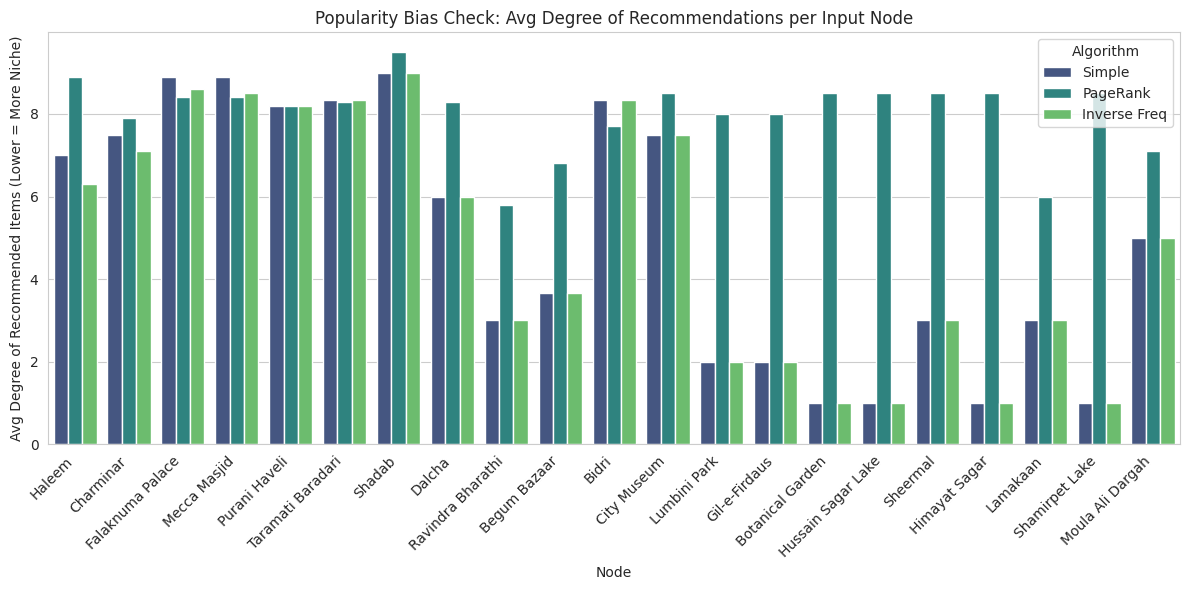

Analysis:
If 'Inverse Freq' (Yellow/Purple) is consistently lower than 'Simple' (Blue),
it confirms the algorithm successfully suppresses generic popular results across ALL inputs.


In [8]:
# --- BATCH EXPERIMENT 1: Recommendation Bias across Categories ---

bias_data = []

print("Running Bias Analysis...")
for start_node in test_batch:
    # 1. Simple
    recs_simple = recommend_simple(G, start_node, top_k=10)
    avg_deg_simple = get_avg_degree(recs_simple)
    bias_data.append({'Node': start_node, 'Type': 'Hub' if start_node in hubs else 'Niche', 
                      'Algorithm': 'Simple', 'Avg_Rec_Degree': avg_deg_simple})
    
    # 2. PageRank
    recs_pr = pagerank_recommend(G, start_node, top_k=10)
    avg_deg_pr = get_avg_degree(recs_pr)
    bias_data.append({'Node': start_node, 'Type': 'Hub' if start_node in hubs else 'Niche', 
                      'Algorithm': 'PageRank', 'Avg_Rec_Degree': avg_deg_pr})
    
    # 3. Inverse Frequency
    recs_idf = recommend_inverse_frequency(G, start_node, top_k=10)
    avg_deg_idf = get_avg_degree(recs_idf)
    bias_data.append({'Node': start_node, 'Type': 'Hub' if start_node in hubs else 'Niche', 
                      'Algorithm': 'Inverse Freq', 'Avg_Rec_Degree': avg_deg_idf})

# Visualization
df_bias = pd.DataFrame(bias_data)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_bias, x='Node', y='Avg_Rec_Degree', hue='Algorithm', palette="viridis")
plt.title("Popularity Bias Check: Avg Degree of Recommendations per Input Node")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Avg Degree of Recommended Items (Lower = More Niche)")
plt.tight_layout()
plt.show()

print("Analysis:")
print("If 'Inverse Freq' (Yellow/Purple) is consistently lower than 'Simple' (Blue),")
print("it confirms the algorithm successfully suppresses generic popular results across ALL inputs.")

Running Pathfinding Stress Test on 21 start nodes...


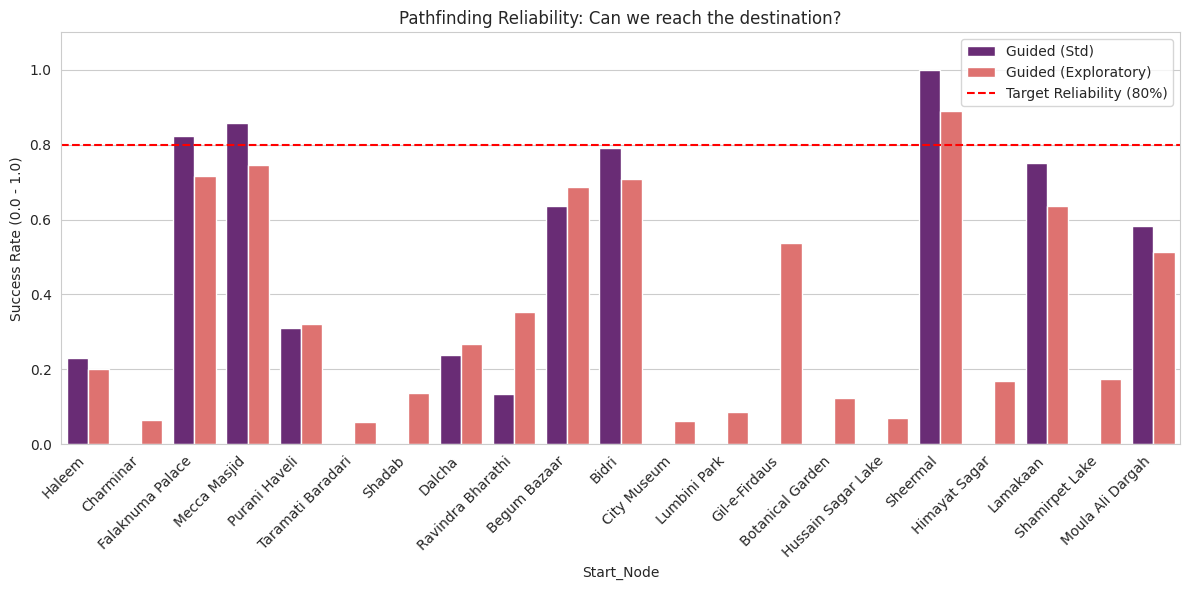

In [9]:
# --- BATCH EXPERIMENT 2: Pathfinding Success Rate ---

path_data = []
runs_per_pair = 1000 # Runs per pair to get an average
print(f"Running Pathfinding Stress Test on {len(test_batch)} start nodes...")

for start_node in test_batch:
    # Pick a random target that isn't the start node
    # We try to pick one that is somewhat distant (path length > 1) if possible
    possible_targets = [n for n in G.nodes() if n != start_node]
    if not possible_targets: continue
        
    target_node = random.choice(possible_targets)
    
    # Run Simulations
    guided_wins = 0
    exploratory_wins = 0
    
    for _ in range(runs_per_pair):
        # Test Guided
        p1 = recommend_guided_walk(G, start_node, target_node, max_steps=15)
        if p1 and p1[-1] == target_node: guided_wins += 1
        
        # Test Guided Exploratory
        p2 = recommend_guided_exploratory_walk(G, start_node, target_node, max_steps=20, teleport_prob=0.15)
        if p2 and p2[-1] == target_node: exploratory_wins += 1
            
    # Store Data
    path_data.append({
        'Start_Node': start_node,
        'Type': 'Hub' if start_node in hubs else 'Niche',
        'Algorithm': 'Guided (Std)',
        'Success_Rate': guided_wins / runs_per_pair
    })
    path_data.append({
        'Start_Node': start_node,
        'Type': 'Hub' if start_node in hubs else 'Niche',
        'Algorithm': 'Guided (Exploratory)',
        'Success_Rate': exploratory_wins / runs_per_pair
    })

# Visualization
df_path = pd.DataFrame(path_data)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_path, x='Start_Node', y='Success_Rate', hue='Algorithm', palette="magma")
plt.axhline(y=0.8, color='r', linestyle='--', label="Target Reliability (80%)")
plt.title("Pathfinding Reliability: Can we reach the destination?")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.ylabel("Success Rate (0.0 - 1.0)")
plt.legend()
plt.tight_layout()
plt.show()

Running Diffusion Analysis...


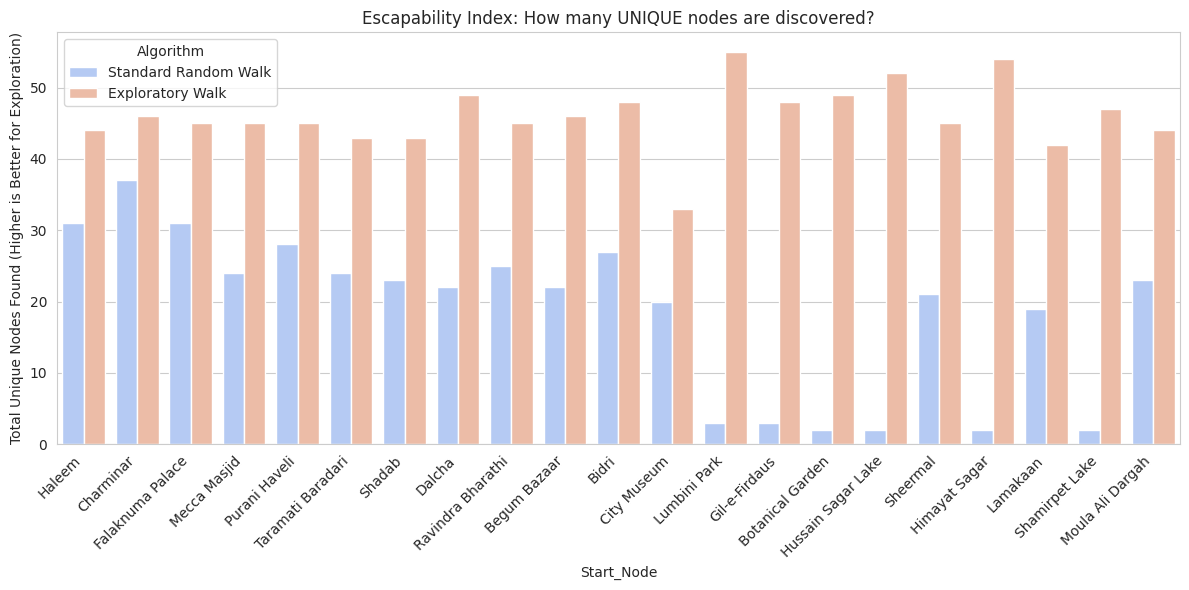

In [10]:
# --- BATCH EXPERIMENT 3: Diffusion / Escapability ---
# Measure: Average unique nodes visited in 100 walks of length 6

diffusion_data = []
print("Running Diffusion Analysis...")

for start_node in test_batch:
    
    # Test Random Walk
    unique_nodes_r = set()
    for _ in range(25):
        path = recommend_random_walk(G, start_node, length=6)
        unique_nodes_r.update(path)
        
    diffusion_data.append({
        'Start_Node': start_node,
        'Algorithm': 'Standard Random Walk',
        'Unique_Nodes_Found': len(unique_nodes_r)
    })
    
    # Test Exploratory Walk
    unique_nodes_e = set()
    for _ in range(25):
        path = recommend_exploratory_walk(G, start_node, length=6, teleport_prob=0.15)
        # Remove annotations for counting
        clean_path = [n.split(' (')[0] for n in path]
        unique_nodes_e.update(clean_path)

    diffusion_data.append({
        'Start_Node': start_node,
        'Algorithm': 'Exploratory Walk',
        'Unique_Nodes_Found': len(unique_nodes_e)
    })

# Visualization
df_diff = pd.DataFrame(diffusion_data)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_diff, x='Start_Node', y='Unique_Nodes_Found', hue='Algorithm', palette="coolwarm")
plt.title("Escapability Index: How many UNIQUE nodes are discovered?")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Total Unique Nodes Found (Higher is Better for Exploration)")
plt.tight_layout()
plt.show()

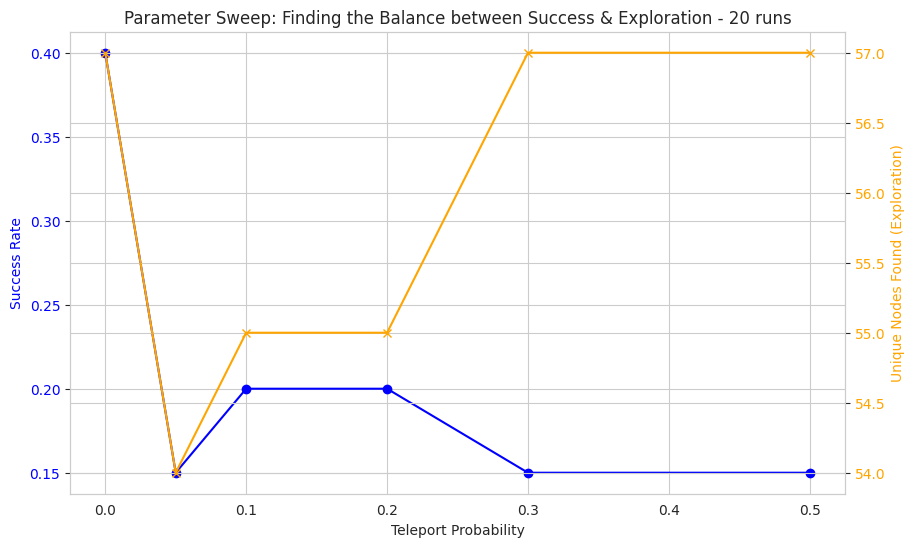

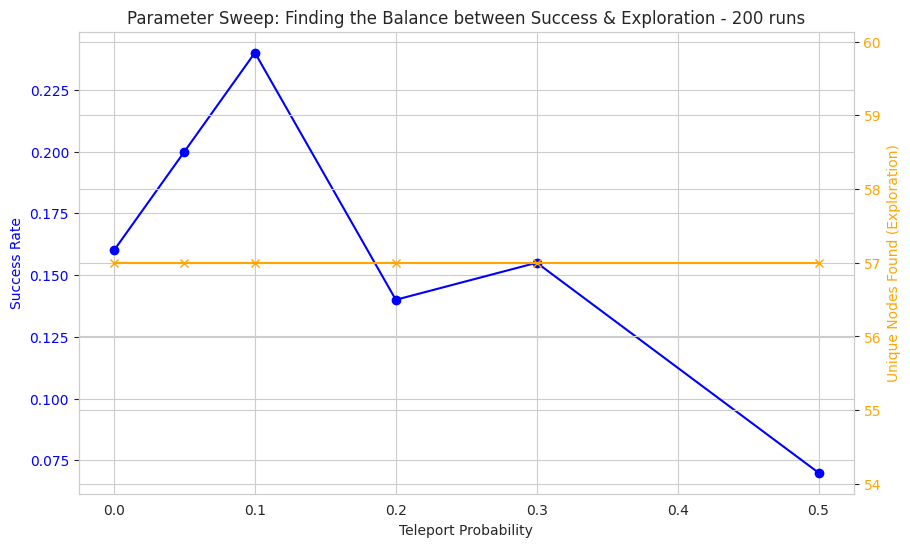

In [11]:
# --- ADDITIONAL EXPERIMENT: Teleport Probability Sweep ---
# How does teleport_prob affect "Exploration" vs "Success Rate"?

teleport_values = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5]
sweep_results = []

start, end = test_batch[0], test_batch[-1] # Pick a fixed pair

for prob in teleport_values:
    successes = 0
    unique_nodes = set()
    
    for _ in range(20): # 20 runs per probability
        path = recommend_guided_exploratory_walk(G, start, end, max_steps=20, teleport_prob=prob)
        if path[-1] == end: successes += 1
        unique_nodes.update([n.split(' (')[0] for n in path])
        
    sweep_results.append({
        'Teleport_Prob': prob,
    'Success_Rate': successes / 20,
        'Unique_Nodes_Found': len(unique_nodes)
    })

df_sweep = pd.DataFrame(sweep_results)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Teleport Probability')
ax1.set_ylabel('Success Rate', color='blue')
ax1.plot(df_sweep['Teleport_Prob'], df_sweep['Success_Rate'], color='blue', marker='o', label='Success Rate')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx() 
ax2.set_ylabel('Unique Nodes Found (Exploration)', color='orange')
ax2.plot(df_sweep['Teleport_Prob'], df_sweep['Unique_Nodes_Found'], color='orange', marker='x', label='Exploration')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Parameter Sweep: Finding the Balance between Success & Exploration - 20 runs")
plt.show()

teleport_values = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5]
sweep_results = []

start, end = test_batch[0], test_batch[-1] # Pick a fixed pair

for prob in teleport_values:
    successes = 0
    unique_nodes = set()
    
    for _ in range(200): # 200 runs per probability
        path = recommend_guided_exploratory_walk(G, start, end, max_steps=20, teleport_prob=prob)
        if path[-1] == end: successes += 1
        unique_nodes.update([n.split(' (')[0] for n in path])
        
    sweep_results.append({
        'Teleport_Prob': prob,
    'Success_Rate': successes / 200,
        'Unique_Nodes_Found': len(unique_nodes)
    })

df_sweep = pd.DataFrame(sweep_results)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Teleport Probability')
ax1.set_ylabel('Success Rate', color='blue')
ax1.plot(df_sweep['Teleport_Prob'], df_sweep['Success_Rate'], color='blue', marker='o', label='Success Rate')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx() 
ax2.set_ylabel('Unique Nodes Found (Exploration)', color='orange')
ax2.plot(df_sweep['Teleport_Prob'], df_sweep['Unique_Nodes_Found'], color='orange', marker='x', label='Exploration')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Parameter Sweep: Finding the Balance between Success & Exploration - 200 runs")
plt.show()

Running pairwise comparison for all 57 nodes...

--- Sample of Jaccard Similarity Scores ---


,Node,Degree,"Jaccard(Simple, PageRank)","Jaccard(Simple, IDF)","Jaccard(PageRank, IDF)"
0,Chicha's,8,0.8,1.0,0.8
1,Qutb Shahi Tombs,4,0.4,1.0,0.4
2,City Museum,2,0.2,1.0,0.2
3,Cafe Bahar,8,0.8,1.0,0.8
4,Nizam Museum,7,0.7,1.0,0.7
5,Toli Masjid,7,0.7,1.0,0.7
6,Osman Sagar,1,0.1,1.0,0.1
7,Paigah Tombs,7,0.7,1.0,0.7
8,Shilparamam,1,0.1,1.0,0.1
9,Snow World,1,0.1,1.0,0.1


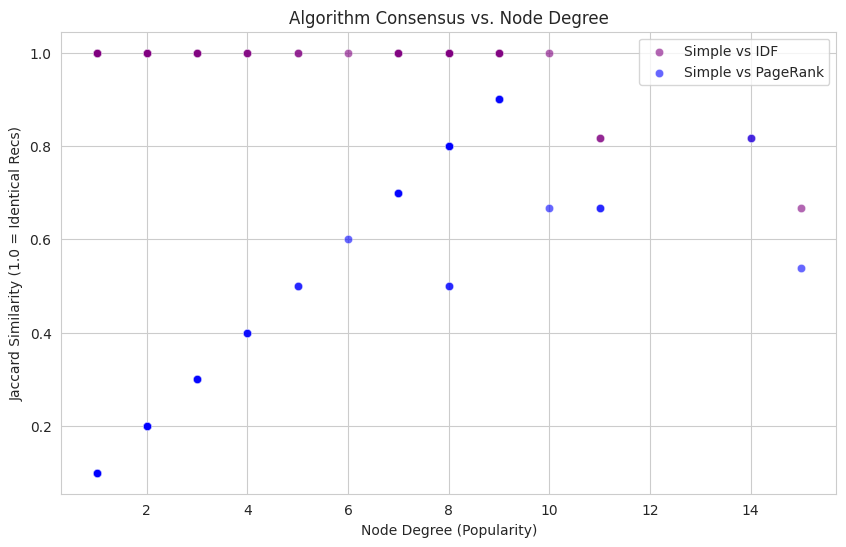

Insight:
- Low Jaccard scores indicate the algorithms are finding DIFFERENT things (High Diversity).
- High Jaccard scores mean the algorithms agree (Low Diversity).


In [12]:
# --- BATCH EXPERIMENT 4: Full Jaccard Similarity Matrix ---
# Calculates algorithm agreement for EVERY node in the graph

print(f"Running pairwise comparison for all {G.number_of_nodes()} nodes...")

similarity_data = []
all_nodes = list(G.nodes())

def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

for node in all_nodes:
    # 1. Get Recommendations (Top 10)
    recs_simple = recommend_simple(G, node, top_k=10)
    recs_pr = pagerank_recommend(G, node, top_k=10)
    recs_idf = recommend_inverse_frequency(G, node, top_k=10)
    
    # 2. Calculate Jaccard Similarities
    # Jaccard = (Intersection) / (Union)
    
    # Agreement between Popularity (Simple) and Structure (PageRank)
    sim_simple_pr = jaccard_similarity(recs_simple, recs_pr)
    
    # Agreement between Popularity (Simple) and Niche (IDF)
    sim_simple_idf = jaccard_similarity(recs_simple, recs_idf)
    
    # Agreement between Structure (PageRank) and Niche (IDF)
    sim_pr_idf = jaccard_similarity(recs_pr, recs_idf)
    
    similarity_data.append({
        'Node': node,
        'Degree': G.degree(node),
        'Jaccard(Simple, PageRank)': sim_simple_pr,
        'Jaccard(Simple, IDF)': sim_simple_idf,
        'Jaccard(PageRank, IDF)': sim_pr_idf
    })

# 3. Create DataFrame
df_jaccard = pd.DataFrame(similarity_data)

# 4. Display & Visualize
print("\n--- Sample of Jaccard Similarity Scores ---")
display(df_jaccard.head(10))

# Plot: Does node degree affect algorithm agreement?
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_jaccard, x='Degree', y='Jaccard(Simple, IDF)', 
                color='purple', label='Simple vs IDF', alpha=0.6)
sns.scatterplot(data=df_jaccard, x='Degree', y='Jaccard(Simple, PageRank)', 
                color='blue', label='Simple vs PageRank', alpha=0.6)

plt.title("Algorithm Consensus vs. Node Degree")
plt.ylabel("Jaccard Similarity (1.0 = Identical Recs)")
plt.xlabel("Node Degree (Popularity)")
plt.legend()
plt.show()

print("Insight:")
print("- Low Jaccard scores indicate the algorithms are finding DIFFERENT things (High Diversity).")
print("- High Jaccard scores mean the algorithms agree (Low Diversity).")

Network Modularity: 0.5638 (Higher > 0.3 indicates strong community structure)

Found 3 major cultural clusters:

🔵 Cluster 0 (The 'Haleem' Cluster):
   Size: 14 nodes
   Members: Chicha's, Cafe Bahar, Hyderabadi Biryani, Hotel Shadab, Osmania Biscuit, Mirchi ka Salan, Khubani ka Meetha, Irani Chai, Shadab, Sarvi, Shah Ghouse, Pista House, Haleem, Grand Hotel

🔵 Cluster 2 (The 'Charminar' Cluster):
   Size: 18 nodes
   Members: Qutb Shahi Tombs, City Museum, Nizam Museum, Toli Masjid, Paigah Tombs, Shilparamam, Purani Haveli, Lassi, Falaknuma Palace, Taramati Baradari, Salar Jung Museum, Mecca Masjid, Spanish Mosque, Golconda Fort, Charminar, Chowmahalla Palace, Laad Bazaar, Bidri

🔵 Cluster 7 (The 'Moazzam Jahi Market' Cluster):
   Size: 5 nodes
   Members: Moazzam Jahi Market, Lamakaan, Ravindra Bharathi, Moula Ali Dargah, Begum Bazaar


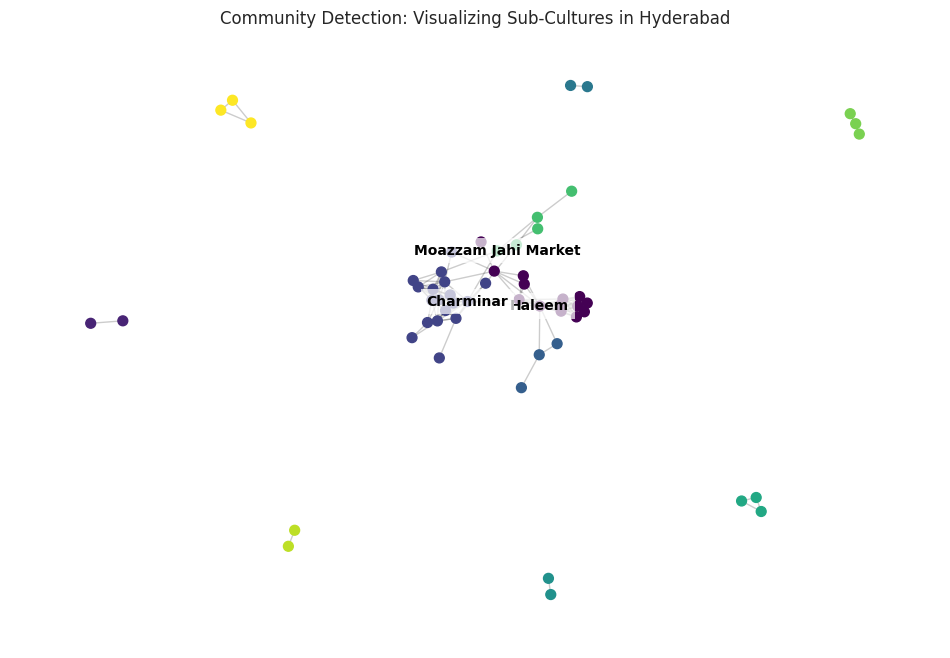

In [13]:
# --- BATCH EXPERIMENT 5: Community Detection Analysis ---
import community.community_louvain as community_louvain
import matplotlib.cm as cm

# 1. Compute Communities (Louvain Algorithm)
partition = community_louvain.best_partition(G, random_state=42)
modularity = community_louvain.modularity(partition, G)

print(f"Network Modularity: {modularity:.4f} (Higher > 0.3 indicates strong community structure)")

# 2. Analyze Communities
# Group nodes by their community ID
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities: communities[comm_id] = []
    communities[comm_id].append(node)

# Filter for significant communities (size > 3)
significant_comms = {k: v for k, v in communities.items() if len(v) > 3}

print(f"\nFound {len(significant_comms)} major cultural clusters:")

for c_id, nodes in significant_comms.items():
    # Find the 'central' node in this community (highest degree)
    central_node = max(nodes, key=lambda x: G.degree(x))
    print(f"\n🔵 Cluster {c_id} (The '{central_node}' Cluster):")
    print(f"   Size: {len(nodes)} nodes")
    print(f"   Members: {', '.join(nodes)}")

# 3. Visualization (Colored by Community)
pos = nx.spring_layout(G, k=0.15, seed=42)
plt.figure(figsize=(12, 8))

# Color nodes by community
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=50,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Label the central nodes of each community
labels = {max(nodes, key=lambda x: G.degree(x)): max(nodes, key=lambda x: G.degree(x)) 
          for c_id, nodes in significant_comms.items()}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold', 
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title("Community Detection: Visualizing Sub-Cultures in Hyderabad")
plt.axis('off')
plt.show()

Training Node2Vec model (learning vector representations of nodes)...


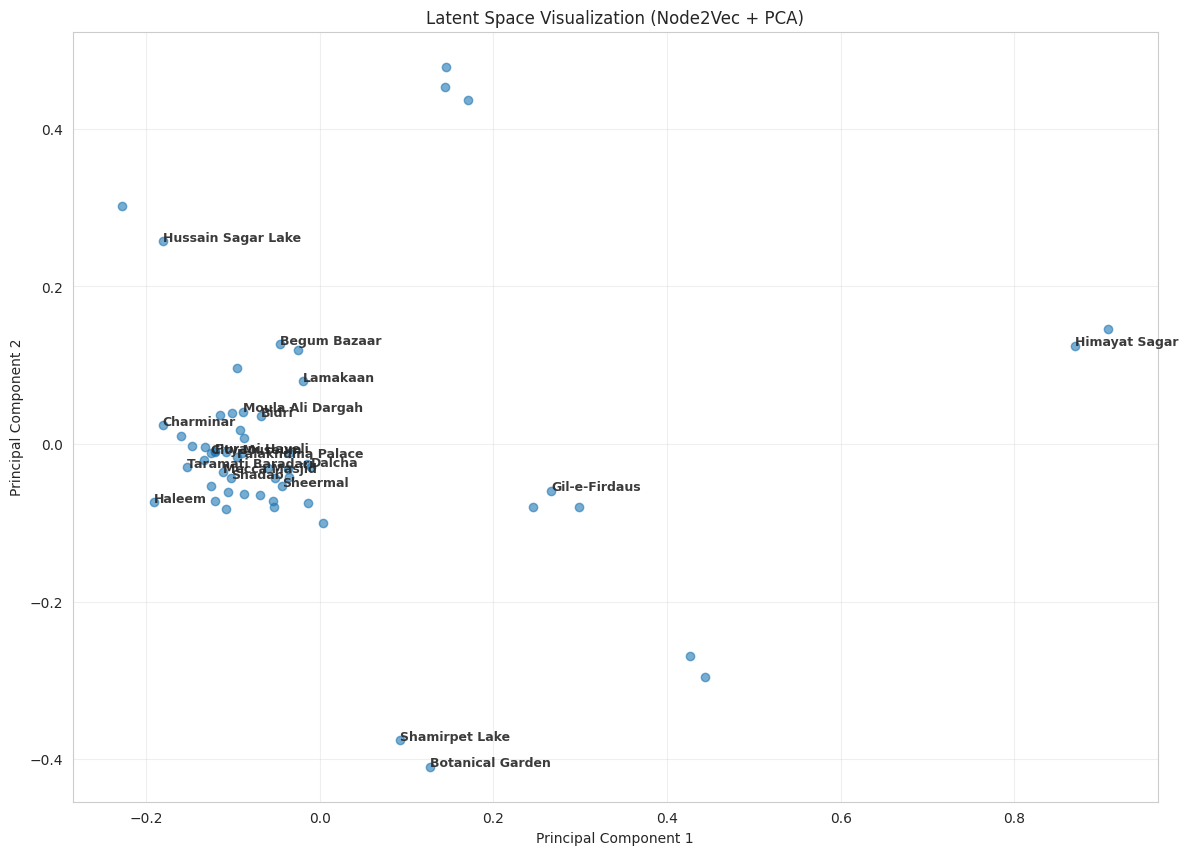

Analysis:
Items that appear close together in this plot are contextually similar.
Clusters here represent 'semantic' groups (e.g., Food items should cluster together away from Monuments).


In [14]:
# --- BATCH EXPERIMENT 6: Graph Embeddings (Latent Space Analysis) ---
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("Training Node2Vec model (learning vector representations of nodes)...")

# 1. Train Node2Vec
# Walk length 10, 10 walks per node
node2vec = Node2Vec(G, dimensions=32, walk_length=10, num_walks=10, workers=1, quiet=True)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# 2. Get Embeddings for all nodes
nodes = [n for n in G.nodes()]
embeddings = [model.wv[n] for n in nodes]

# 3. Reduce to 2D for visualization (Using PCA)
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(embeddings)

# 4. Visualization
plt.figure(figsize=(14, 10))

# Scatter plot
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], alpha=0.6)

# Annotate distinctive nodes
# We annotate the 'Hubs' and some random 'Niche' nodes to see separation
annotate_list = hubs + niche + random.sample(mid_tier, min(len(mid_tier), 5))

for i, node in enumerate(nodes):
    if node in annotate_list:
        plt.annotate(node, xy=(node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]),
                     fontsize=9, alpha=0.9, weight='bold')

plt.title("Latent Space Visualization (Node2Vec + PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, alpha=0.3)
plt.show()

print("Analysis:")
print("Items that appear close together in this plot are contextually similar.")
print("Clusters here represent 'semantic' groups (e.g., Food items should cluster together away from Monuments).")